# Abalore Rings Prediction Model

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from IPython.display import clear_output, display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
	for filename in filenames:
		print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Dataset Analysis

In [5]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('./input/playground-series-s4e4/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
# Display the first 5 examples
dataset_df.head(5)

Full train dataset shape is (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [81]:
print(len(dataset_df['Rings'].unique()))
dataset_df['Rings'].unique()

28


array([11,  6, 10,  9,  4,  8, 15,  7, 12, 20, 17, 13, 14,  5, 23,  3, 22,
       16, 18, 19, 21, 25,  1, 29,  2, 27, 24, 26])

### NAN checks

Thankfully no null values.

In [7]:
dataset_df.isnull().sum().sort_values(ascending=False)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

### Gender Analysis

In [8]:
print("Sex:")
print(dataset_df.Sex.describe())
print(dataset_df.Sex.unique())

Sex:
count     90615
unique        3
top           I
freq      33093
Name: Sex, dtype: object
['F' 'I' 'M']


There seems to be some correlation between the size of the Abalone's and its gender. This makes sense since infants are usually smaller than the adults.

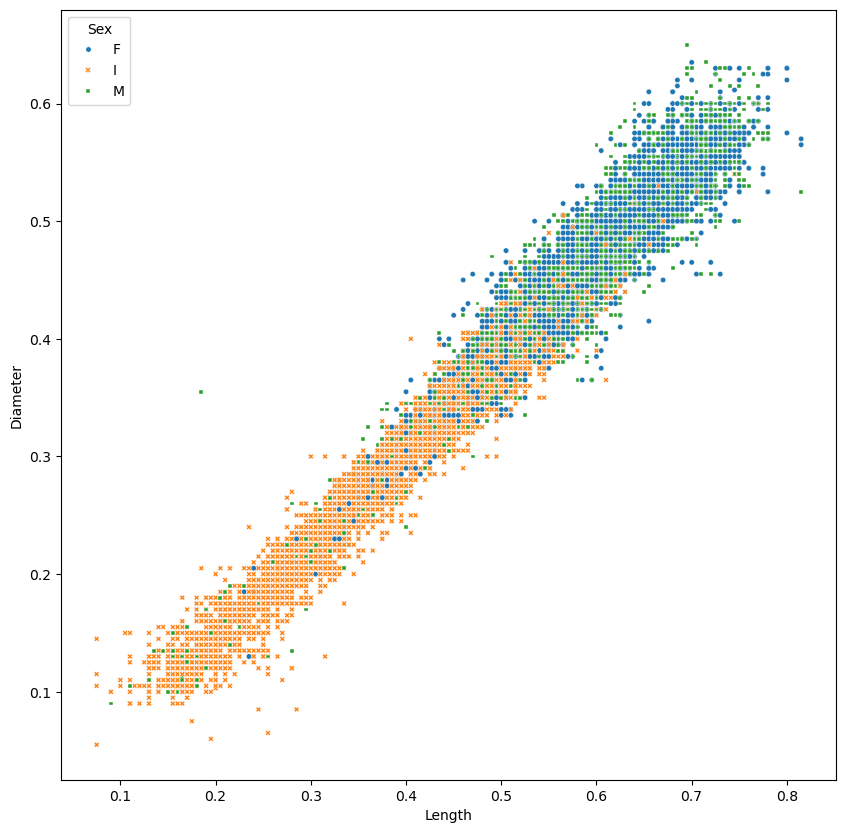

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.scatterplot(data=dataset_df, x='Length', y='Diameter', hue='Sex', ax=ax, s=15, style="Sex")
plt.show()

In [10]:
dataset_df.describe(include='all')

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,33093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,45307.000000,NaN,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,NaN,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,NaN,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,NaN,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,NaN,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000


### Weight Analysis

Apparently `Whole weight.1` and `Whole weight.2` mean `Shucked Weight` and `Viscera Weight`, according to https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488073. For my own convenience, I'm renaming these columns. It seems that the sum of the weights `shucked` and `shell`, or the total weight of the Abalone post shucking, should be strictly less than the `weight_whole`.

In [11]:
dataset_df['weight_whole'] = dataset_df['Whole weight']
dataset_df['weight_shucked'] = dataset_df['Whole weight.1']
dataset_df['weight_viscera'] = dataset_df['Whole weight.2']
dataset_df['weight_shell'] = dataset_df['Shell weight']
dataset_df.drop(columns=['Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'], inplace=True)

There are roughly 296 entries where the sum of the post-shucking weights are greater than the whole weight, which is unlikely. One abalone almost a third of its own weight.

In [12]:
w_cols = ['weight_shucked', 'weight_shell']
dataset_df['weight_sum'] = dataset_df[w_cols].sum(axis=1)
print((dataset_df['weight_sum'] <= dataset_df['weight_whole']).value_counts())
print()
print(f"mean: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).mean()}")
print(f"std: {((dataset_df['weight_whole'] - dataset_df['weight_sum']) > 0).std()}")
print()
weight_outliers = dataset_df.loc[(dataset_df['weight_sum'] > dataset_df['weight_whole'])]
print(weight_outliers.id.count())
print(f"mean: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).mean()}")
print(f"std: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).std()}")
print(f"max: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).max()}")
print(f"min: {(weight_outliers['weight_sum'] - weight_outliers['weight_whole']).min()}")
print()
# abalone that gained 0.4595g after being shucked had a whole weight of 1.218g
odd_id = (weight_outliers['weight_sum'] - weight_outliers['weight_whole']).argmax()
dataset_df['weight_whole'][odd_id]

True     90319
False      296
Name: count, dtype: int64

mean: 0.9965347900457981
std: 0.058764278121165886

296
mean: 0.04483614864864865
std: 0.10479788947301452
max: 0.4595
min: 3.469446951953614e-18



1.218

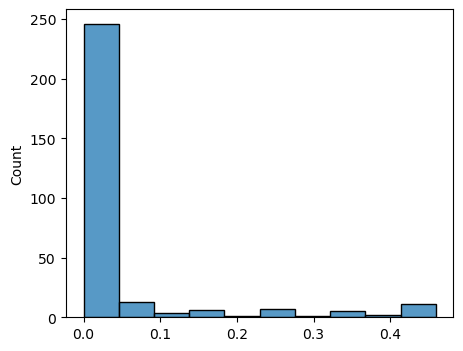

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

sns.histplot(data=(weight_outliers['weight_sum'] - weight_outliers['weight_whole']), bins=10, ax=ax)
plt.show()

For now, we'll simply drop the outliers. Maybe later we could include the outliers whose difference between `weight_shucked + weight_shell` and `weight_whole` is negligible.

In [14]:
dataset_df.drop(dataset_df.loc[dataset_df['weight_sum'] > dataset_df['weight_whole']].index, inplace=True)

We can see that no abalones have `weight_shucked`, `weight_shell`, or `weight_viscera` greater than `weight_whole`.

In [15]:
print((dataset_df['weight_shucked'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_shell'] < dataset_df['weight_whole']).value_counts())
print((dataset_df['weight_viscera'] < dataset_df['weight_whole']).value_counts())

True    90319
Name: count, dtype: int64
True    90319
Name: count, dtype: int64
True    90319
Name: count, dtype: int64


### Heigh, Diameter, Length

We'll also drop the few abalones with height 0.

In [16]:
dataset_df.loc[(dataset_df['Height'] == 0)].count()

id                4
Sex               4
Length            4
Diameter          4
Height            4
Rings             4
weight_whole      4
weight_shucked    4
weight_viscera    4
weight_shell      4
weight_sum        4
dtype: int64

In [17]:
dataset_df.drop(dataset_df.loc[(dataset_df['Height'] == 0)].index, inplace=True)

### Feature Correlation

We can observe high correlation between all numerical features, which is expected. Don't think there's much point to applying pca here though, considering we have only 7 input features to work with.

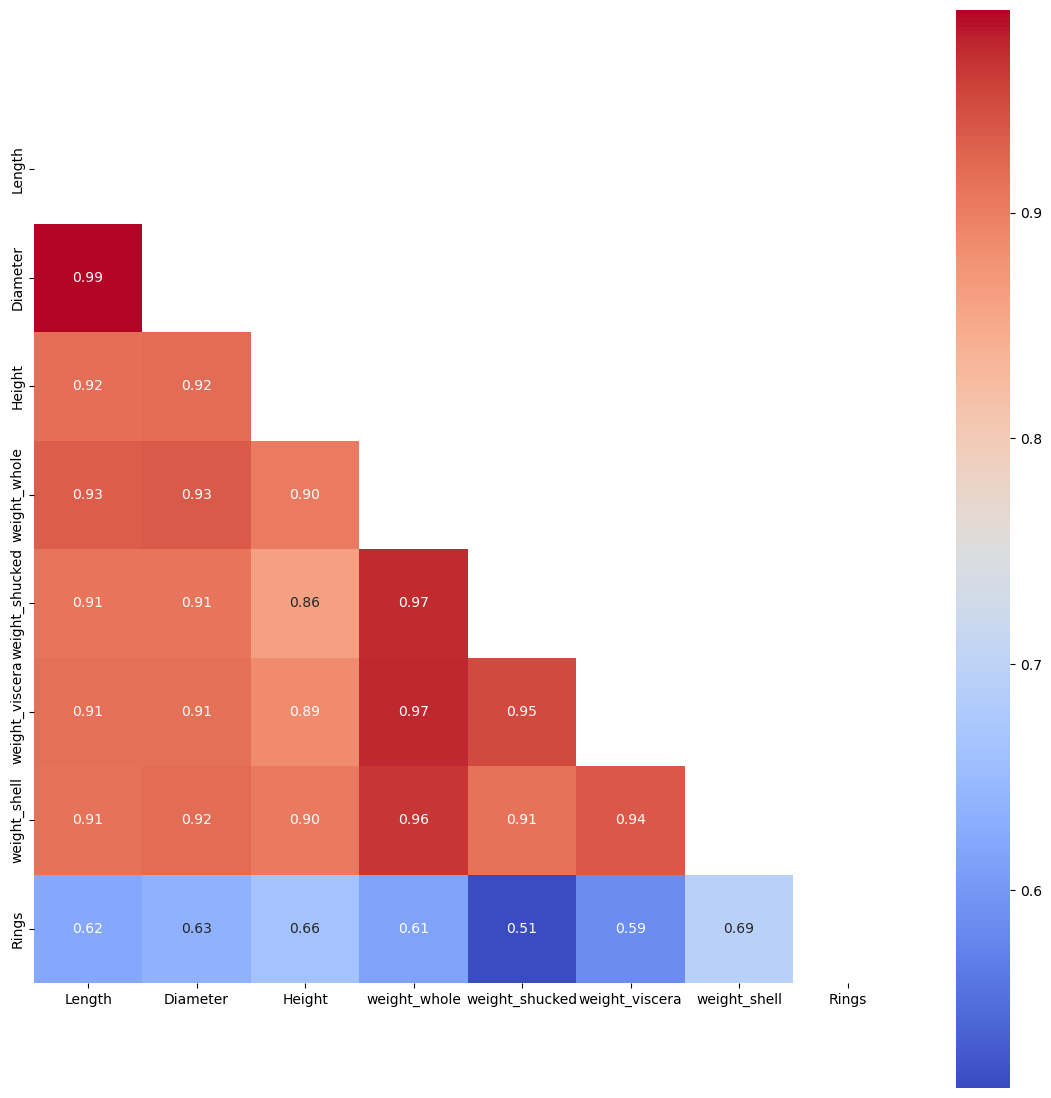

In [18]:
# reorganizing columns
dataset_df = dataset_df[[col for col in dataset_df.columns if col != 'Rings'] + ['Rings']]

corr = dataset_df.drop(columns=['Sex', 'id', 'weight_sum']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cmap='coolwarm')
plt.show()

### Training

In [19]:
X = dataset_df.drop(columns=['weight_sum', 'Rings', 'Sex', 'id'])
y = dataset_df['Rings']
# X['sex_M'] = (dataset_df['Sex'] == 'M').astype(float)
# X['sex_F'] = (dataset_df['Sex'] == 'F').astype(float)
# X['sex_I'] = (dataset_df['Sex'] == 'I').astype(float)
def sex_to_int(x):
	if x == 'M':
		return 0
	elif x == 'F':
		return 1
	else:
		return 2
X['sex'] = dataset_df['Sex'].apply(sex_to_int)
X.head()

,Length,Diameter,Height,weight_whole,weight_shucked,weight_viscera,weight_shell,sex
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,2
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,0
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,2


In [20]:
X_train, X_test, y_train, y_test = \
	train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [21]:
class AbaloneDataset(data.Dataset):
	def __init__(self, X_df, y_df):
		self.X = torch.Tensor(X_df.values)
		self.y = torch.Tensor(y_df.values)
		self.l = self.X.shape[0]
	
	def __getitem__(self, index):
		return self.X[index], self.y[index]
	
	def __len__(self):
		return self.l

In [22]:
# the evaluation metric, root mean squared logarithmic error
class RMSLELoss(nn.Module):
	def __init__(self):
		super().__init__()
		self.mse = nn.MSELoss()
		
	def forward(self, pred, actual):
		return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [23]:
train_dataset = AbaloneDataset(X_train, y_train)
test_dataset = AbaloneDataset(X_test, y_test)

## Regression Model

Define Model and Trainer class.

In [24]:
# simple linear regression model with an embedding layer for genders
class AbaloreRingLR(nn.Module):
	def __init__(self, num_hidden=2, dim_hidden=32, dim_input=7, num_sex=3, dim_sex_embed=2):
		super(AbaloreRingLR, self).__init__()
		self.num_sex = num_sex
		# embeddings for the gender
		self.sex_embed = nn.Embedding(num_sex, dim_sex_embed) 
		self.l1 = nn.Sequential(
			nn.Linear(dim_input+dim_sex_embed, dim_hidden),
			nn.LeakyReLU(),
		)
		self.lh = nn.ModuleList([
			nn.Sequential(
				nn.Linear(dim_hidden, dim_hidden),
				nn.LeakyReLU(),
			) for _ in range(num_hidden)
		])
		self.lo = nn.Linear(dim_hidden, 1)
	
	def forward(self, inputs, gender):
		embedded_sex = self.sex_embed(gender)
		X = torch.cat((inputs, embedded_sex), dim=1)
		h = self.l1(X)
		for hidden in self.lh:
			h = hidden(h)
		h = self.lo(h)
		return torch.exp(h) # ensure output is positive

In [25]:
# simple linear regression model with a sigmoid activation at the final layer for an output range
class AbaloreRingLRSigmoid(nn.Module):
	def __init__(self, num_hidden=2, dim_hidden=32, dim_input=7, num_sex=3, dim_sex_embed=2, dropout=0.2):
		super(AbaloreRingLRSigmoid, self).__init__()
		self.num_sex = num_sex
		# embeddings for the gender
		self.sex_embed = nn.Embedding(num_sex, dim_sex_embed) 
		self.l1 = nn.Sequential(
			nn.Linear(dim_input+dim_sex_embed, dim_hidden),
			nn.LeakyReLU(),
		)
		self.lh = nn.ModuleList([
			nn.Sequential(
				nn.Linear(dim_hidden, dim_hidden),
				nn.Dropout(p=dropout),
				nn.LeakyReLU(),
			) for _ in range(num_hidden)
		])
		self.lo = nn.Linear(dim_hidden, 1)
	
	def forward(self, inputs, gender):
		embedded_sex = self.sex_embed(gender)
		X = torch.cat((inputs, embedded_sex), dim=1)
		h = self.l1(X)
		for hidden in self.lh:
			h = hidden(h)
		h = self.lo(h)
		return 30 * F.sigmoid(h) # ensure output is positive

In [124]:
class Trainer:
    def __init__(self, model):
        self.model = model
    
    def get_model(self):
      return self.model
    
    def train(self, train_dataset, val_dataset, loss_fn, batch_size=128, lr=1e4, lambda_=5e3, epochs=50):
        train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, amsgrad=False)

        train_losses = []
        val_losses = []
        train_perf = []
        val_perf = []
        
        for epoch in range(epochs):
            # clear_output(wait=True)
            print(f"epoch {epoch+1} / {epochs}")

            total_loss = 0.
            train_rmsle = 0.
            perplexity = 0.
            total_loss = 0.

            for i, (X, y) in enumerate(train_loader):
                self.model.train()

                X_inputs, X_genders = torch.split(X, [7,1], dim=1)
                y_hat = self.model(X_inputs, X_genders.squeeze().long()).squeeze()

                loss = loss_fn(y_hat, y)
                l2_reg = 0
                for parameter in self.model.parameters():
                    l2_reg = l2_reg + torch.sum(torch.pow(parameter, 2)) * .5
                loss = loss + l2_reg * lambda_
                total_loss = total_loss + loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # rmsle of the training set
                with torch.no_grad():
                    train_rmsle = train_rmsle + torch.sum(torch.pow(torch.log(y_hat + 1) - \
                                                                     torch.log(y + 1), 2))

                # cross val
                if i % 100 == 99:
                    self.model.eval()
                    with torch.no_grad():
                        val_rmsle = 0.
                        val_loss = 0.
                        for j, (val_X, val_y) in enumerate(val_loader):
                            val_X_inputs, val_X_genders = torch.split(val_X, [7,1], dim=1)
                            val_y_hat = self.model(val_X_inputs, val_X_genders.squeeze().long()).squeeze()
                            val_rmsle = val_rmsle + torch.sum(torch.pow(torch.log(val_y_hat + 1) - \
                                                                torch.log(val_y + 1), 2))
                            val_loss = val_loss + loss_fn(val_y_hat, val_y)
                        val_rmsle = torch.sqrt(val_rmsle / len(val_dataset))
                        print(f"val_rmsle: {val_rmsle}")
                        val_perf.append(val_rmsle)
                        val_loss = val_loss
                        val_losses.append(val_loss / len(val_loader))
                        
            train_rmsle = torch.sqrt(train_rmsle / len(train_dataset))
            train_perf.append(train_rmsle)
            train_losses.append(total_loss / len(train_loader))
        
        return train_losses, val_losses, train_perf, val_perf

In [126]:
trainer_1 = Trainer(AbaloreRingLRSigmoid(num_hidden=1, dim_hidden=128, dim_sex_embed=1, dropout=0.2))
train_losses, val_losses, train_metrics, val_metrics = trainer_1.train( \
	train_dataset=train_dataset, val_dataset=test_dataset, loss_fn=nn.MSELoss(), \
	batch_size=128, lr=.0001, lambda_=.001, epochs=50)

epoch 1 / 50
val_rmsle: 0.38213050365448
val_rmsle: 0.3379366397857666
val_rmsle: 0.28995367884635925
val_rmsle: 0.24597041308879852
val_rmsle: 0.22163593769073486
epoch 2 / 50
val_rmsle: 0.2070118933916092
val_rmsle: 0.20151515305042267
val_rmsle: 0.19699528813362122
val_rmsle: 0.19466006755828857
val_rmsle: 0.1898770034313202
epoch 3 / 50
val_rmsle: 0.18734504282474518
val_rmsle: 0.18339858949184418
val_rmsle: 0.18141427636146545
val_rmsle: 0.18225978314876556
val_rmsle: 0.17894414067268372
epoch 4 / 50
val_rmsle: 0.17570027709007263
val_rmsle: 0.172620490193367
val_rmsle: 0.17050915956497192
val_rmsle: 0.17117585241794586
val_rmsle: 0.16831199824810028
epoch 5 / 50
val_rmsle: 0.16612134873867035
val_rmsle: 0.16808947920799255
val_rmsle: 0.16407300531864166
val_rmsle: 0.16481761634349823
val_rmsle: 0.16278493404388428
epoch 6 / 50
val_rmsle: 0.1616874784231186
val_rmsle: 0.1615733951330185
val_rmsle: 0.1614624708890915
val_rmsle: 0.1597868651151657
val_rmsle: 0.15931032598018646
epoc

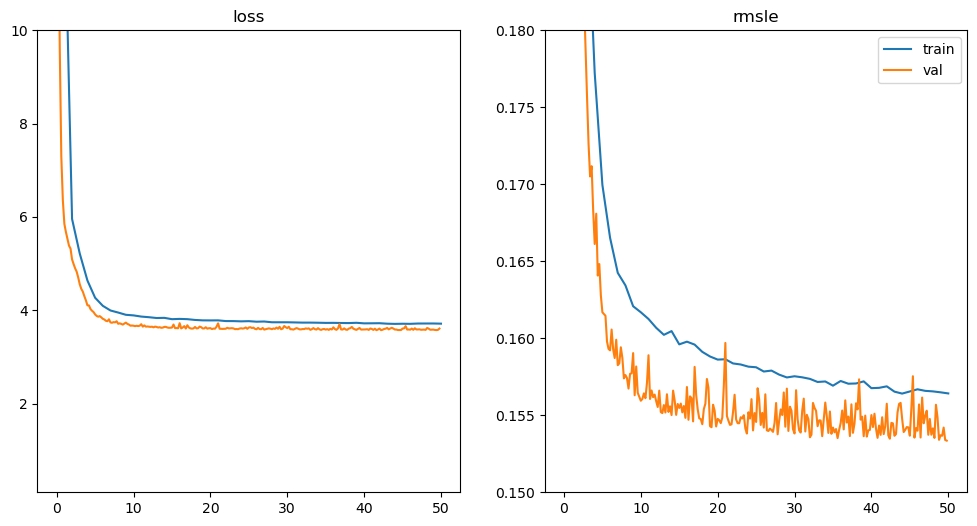

tensor(0.1534)


In [127]:
eval_per_epoch = len(val_metrics) / len(train_metrics)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,6)

ax[0].plot([i + 1 for i in range(len(train_losses))], train_losses, label='train')
ax[0].plot([i / eval_per_epoch for i in range(len(val_losses))], val_losses, label='val')
ax[0].set_ylim(0.1, 10.)
ax[0].set_title('loss')

ax[1].plot([i + 1 for i in range(len(train_metrics))], train_metrics, label='train')
ax[1].plot([i / eval_per_epoch for i in range(len(val_metrics))], val_metrics, label='val')
ax[1].set_ylim(0.15, 0.18)
ax[1].set_title('rmsle')

plt.legend()
plt.show()

print(val_metrics[-1])

## Classification Model

Instead of predicitng the number of Rings, we assign a given Abalone to one of the observed 28 Ring classifications. First we have to adjust the targets so that they are within the range of 0 to 27.

In [117]:
# train_dataset = AbaloneDataset(X_train, y_train)
# test_dataset = AbaloneDataset(X_test, y_test)
def adjust_target(x):
	if x < 28:
		return x-1
	else:
		return x-2

def revert_target(x):
    if x < 27:
        return x + 1
    else:
        return x + 2

train_dataset_2 = AbaloneDataset(X_train, y_train.apply(adjust_target))
test_dataset_2 = AbaloneDataset(X_test, y_test.apply(adjust_target))

In [114]:
# simple linear regression model with a sigmoid activation at the final layer for an output range
class AbaloreRingClassifier(nn.Module):
	def __init__(self, num_hidden=2, dim_hidden=32, dim_input=7, dim_output=28, num_sex=3, dim_sex_embed=2, dropout=0.2):
		super(AbaloreRingClassifier, self).__init__()
		self.num_sex = num_sex
		# embeddings for the gender
		self.sex_embed = nn.Embedding(num_sex, dim_sex_embed) 
		self.l1 = nn.Sequential(
			nn.Linear(dim_input+dim_sex_embed, dim_hidden),
			nn.LeakyReLU(),
		)
		self.lh = nn.ModuleList([
			nn.Sequential(
				nn.Linear(dim_hidden, dim_hidden),
				nn.Dropout(p=dropout),
				nn.LeakyReLU(),
			) for _ in range(num_hidden)
		])
		self.lo = nn.Linear(dim_hidden, dim_output)
	
	def forward(self, inputs, gender):
		embedded_sex = self.sex_embed(gender)
		X = torch.cat((inputs, embedded_sex), dim=1)
		h = self.l1(X)
		for hidden in self.lh:
			h = hidden(h)
		h = self.lo(h)
		return F.log_softmax(h, dim=1)

In [119]:
class Trainer2:
    def __init__(self, model):
        self.model = model
    
    def get_model(self):
      return self.model
    
    def train(self, train_dataset, val_dataset, batch_size=128, lr=1e4, lambda_=5e3, epochs=50):
        train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, amsgrad=False)

        train_losses = []
        val_losses = []
        train_perf = []
        val_perf = []
        
        for epoch in range(epochs):
            # clear_output(wait=True)
            print(f"epoch {epoch+1} / {epochs}")

            total_loss = 0.
            train_rmsle = 0.
            perplexity = 0.
            total_loss = 0.
            
            loss_fn = nn.NLLLoss()

            for i, (X, y) in enumerate(train_loader):
                self.model.train()

                X_inputs, X_genders = torch.split(X, [7,1], dim=1)
                y_hat = self.model(X_inputs, X_genders.squeeze().long()).squeeze()

                loss = loss_fn(y_hat, y.long())
                l2_reg = 0
                for parameter in self.model.parameters():
                    l2_reg = l2_reg + torch.sum(torch.pow(parameter, 2)) * .5
                loss = loss + l2_reg * lambda_
                total_loss = total_loss + loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # rmsle of the training set
                with torch.no_grad():
                    train_rmsle = train_rmsle + torch.sum(torch.pow(torch.log((torch.argmax(y_hat, dim=1)) + 1) - \
                                                                     torch.log((y) + 1), 2))

                # cross val
                if i % 100 == 99:
                    self.model.eval()
                    with torch.no_grad():
                        val_rmsle = 0.
                        val_loss = 0.
                        for j, (val_X, val_y) in enumerate(val_loader):
                            val_X_inputs, val_X_genders = torch.split(val_X, [7,1], dim=1)
                            val_y_hat = self.model(val_X_inputs, val_X_genders.squeeze().long()).squeeze()
                            val_rmsle = val_rmsle + torch.sum(torch.pow(torch.log((torch.argmax(val_y_hat, dim=1)) + 1) - \
                                                                torch.log((val_y) + 1), 2))
                            val_loss = val_loss + loss_fn(val_y_hat, val_y.long())
                        val_rmsle = torch.sqrt(val_rmsle / len(val_dataset))
                        print(f"val_rmsle: {val_rmsle}")
                        val_perf.append(val_rmsle)
                        val_loss = val_loss
                        val_losses.append(val_loss / len(val_loader))
                        
            train_rmsle = torch.sqrt(train_rmsle / len(train_dataset))
            train_perf.append(train_rmsle)
            train_losses.append(total_loss / len(train_loader))
        
        return train_losses, val_losses, train_perf, val_perf

In [130]:
trainer_2 = Trainer2(AbaloreRingClassifier(num_hidden=1, dim_hidden=128, dim_input=7, dim_output=29, num_sex=3, dim_sex_embed=1, dropout=0.))
train_losses_2, val_losses_2, train_metrics_2, val_metrics_2 = trainer_2.train( \
	train_dataset=train_dataset_2, val_dataset=test_dataset_2, \
	batch_size=128, lr=.0001, lambda_=0.01, epochs=100)

epoch 1 / 100
val_rmsle: 0.3486201763153076
val_rmsle: 0.3360077738761902
val_rmsle: 0.29306724667549133
val_rmsle: 0.29299500584602356
val_rmsle: 0.29275164008140564
epoch 2 / 100
val_rmsle: 0.2849889397621155
val_rmsle: 0.2744571268558502
val_rmsle: 0.26099154353141785
val_rmsle: 0.26382264494895935
val_rmsle: 0.25664985179901123
epoch 3 / 100
val_rmsle: 0.2574678957462311
val_rmsle: 0.25867849588394165
val_rmsle: 0.2558137774467468
val_rmsle: 0.2570986747741699
val_rmsle: 0.25219306349754333
epoch 4 / 100
val_rmsle: 0.24948646128177643
val_rmsle: 0.2510133981704712
val_rmsle: 0.2484097182750702
val_rmsle: 0.24901272356510162
val_rmsle: 0.24920988082885742
epoch 5 / 100
val_rmsle: 0.245170459151268
val_rmsle: 0.2471991926431656
val_rmsle: 0.24681076407432556
val_rmsle: 0.24683189392089844
val_rmsle: 0.24677439033985138
epoch 6 / 100
val_rmsle: 0.24748347699642181
val_rmsle: 0.24511322379112244
val_rmsle: 0.24742622673511505
val_rmsle: 0.24424980580806732
val_rmsle: 0.2462407350540161

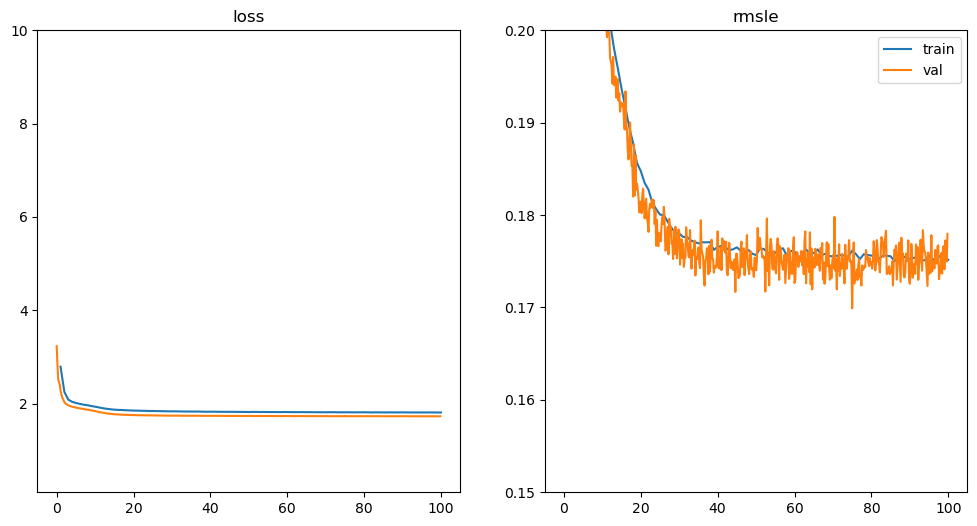

tensor(0.1759)


In [112]:
eval_per_epoch = len(val_metrics_2) / len(train_metrics_2)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,6)

ax[0].plot([i + 1 for i in range(len(train_losses_2))], train_losses_2, label='train')
ax[0].plot([i / eval_per_epoch for i in range(len(val_losses_2))], val_losses_2, label='val')
ax[0].set_ylim(0.1, 10.)
ax[0].set_title('loss')

ax[1].plot([i + 1 for i in range(len(train_metrics_2))], train_metrics_2, label='train')
ax[1].plot([i / eval_per_epoch for i in range(len(val_metrics_2))], val_metrics_2, label='val')
ax[1].set_ylim(0.15, 0.2)
ax[1].set_title('rmsle')

plt.legend()
plt.show()

print(val_metrics[-1])

Test output to confirm that the rmsle calculation is correct.

In [ ]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
test_df.head(5)

In [ ]:
test_X_df = test_df.drop(columns=['Sex', 'id'])
def sex_to_int(x):
	if x == 'M':
		return 0
	elif x == 'F':
		return 1
	else:
		return 2
test_X_df['sex'] = test_df['Sex'].apply(sex_to_int)
test_X_df.head()

In [ ]:
test_X = torch.Tensor(test_X_df.values)
test_X_inputs, test_X_genders = torch.split(test_X, [7,1], dim=1)
model.eval()
with torch.no_grad():
	test_y_hat = model(test_X_inputs, test_X_genders.squeeze().long()).squeeze()
submission['Rings'] = test_y_hat

In [ ]:
submission.to_csv("submission.csv", index = False)